# 1 - Data Preperation


### Mount Google Drive and Unzip Dataset


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/mel_classification/mel_classification.zip" -d "/content/mel_classification"

### Import Required Libraries


In [ ]:
import os
import random
import shutil

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from keras.utils import register_keras_serializable
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

### Set Seed for Reproducibility


In [5]:
SEED = 55
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Load and Explore the Balanced Dataset


In [6]:
df = pd.read_csv('/content/mel_classification/mel_classification.csv')
df

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0054974,mel,malignant,1,../data/ISIC_2019/train/ISIC_0054974.jpg
1,ISIC_0064188,bkl,benign,0,../data/ISIC_2019/train/ISIC_0064188.jpg
2,ISIC_0000026_downsampled,mel,malignant,1,../data/ISIC_2019/train/ISIC_0000026_downsampl...
3,ISIC_0032535,mel,malignant,1,../data/ISIC_2019/train/ISIC_0032535.jpg
4,ISIC_0054624,mel,malignant,1,../data/ISIC_2019/train/ISIC_0054624.jpg
...,...,...,...,...,...
10207,ISIC_0025368,akiec,benign,0,../data/ISIC_2019/train/ISIC_0025368.jpg
10208,ISIC_0056108,nv,benign,0,../data/ISIC_2019/train/ISIC_0056108.jpg
10209,ISIC_0033128,nv,benign,0,../data/ISIC_2019/train/ISIC_0033128.jpg
10210,ISIC_0014076_downsampled,mel,malignant,1,../data/ISIC_2019/train/ISIC_0014076_downsampl...


#### Distribution


In [7]:
df['benign_malignant'].value_counts()

,count
benign_malignant,
malignant,5106
benign,5106


In [8]:
df['target'].value_counts()

,count
target,
1,5106
0,5106


### Split Data into Train, Validation and Test Sets


In [9]:
X = df[['image_name', 'path']]
y = df['benign_malignant']

In [10]:
X

,image_name,path
0,ISIC_0054974,../data/ISIC_2019/train/ISIC_0054974.jpg
1,ISIC_0064188,../data/ISIC_2019/train/ISIC_0064188.jpg
2,ISIC_0000026_downsampled,../data/ISIC_2019/train/ISIC_0000026_downsampl...
3,ISIC_0032535,../data/ISIC_2019/train/ISIC_0032535.jpg
4,ISIC_0054624,../data/ISIC_2019/train/ISIC_0054624.jpg
...,...,...
10207,ISIC_0025368,../data/ISIC_2019/train/ISIC_0025368.jpg
10208,ISIC_0056108,../data/ISIC_2019/train/ISIC_0056108.jpg
10209,ISIC_0033128,../data/ISIC_2019/train/ISIC_0033128.jpg
10210,ISIC_0014076_downsampled,../data/ISIC_2019/train/ISIC_0014076_downsampl...


In [11]:
y

,benign_malignant
0,malignant
1,benign
2,malignant
3,malignant
4,malignant
...,...
10207,benign
10208,benign
10209,benign
10210,malignant


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#### Display Class Distribution in Train, Validation, and Test Sets


In [13]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Train:", df_train['benign_malignant'].value_counts().to_dict())

Train: {'malignant': 3676, 'benign': 3676}


In [14]:
df_val = pd.concat([X_val, y_val], axis=1)
print("Validation:", df_val['benign_malignant'].value_counts().to_dict())

Validation: {'malignant': 919, 'benign': 919}


In [15]:
df_test = pd.concat([X_test, y_test], axis=1)
print("Test:", df_test['benign_malignant'].value_counts().to_dict())

Test: {'malignant': 511, 'benign': 511}


### Update Image Paths for Google Colab Environment


In [ ]:
NEW_ROOT = "/content/mel_classification/mel_images"

df_train['path'] = df_train['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_val['path'] = df_val['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_test['path'] = df_test['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))

In [17]:
df_train

,image_name,path,benign_malignant
3848,ISIC_0058285,/content/mel_classification/mel_images/ISIC_00...,malignant
1753,ISIC_0069508,/content/mel_classification/mel_images/ISIC_00...,malignant
5533,ISIC_0033595,/content/mel_classification/mel_images/ISIC_00...,malignant
6996,ISIC_0056535,/content/mel_classification/mel_images/ISIC_00...,benign
2490,ISIC_0071272,/content/mel_classification/mel_images/ISIC_00...,benign
...,...,...,...
6938,ISIC_0014079_downsampled,/content/mel_classification/mel_images/ISIC_00...,malignant
7976,ISIC_0027492,/content/mel_classification/mel_images/ISIC_00...,benign
6349,ISIC_0031586,/content/mel_classification/mel_images/ISIC_00...,malignant
7164,ISIC_0032231,/content/mel_classification/mel_images/ISIC_00...,benign


In [18]:
df_val

,image_name,path,benign_malignant
6471,ISIC_0056710,/content/mel_classification/mel_images/ISIC_00...,malignant
1818,ISIC_0066354,/content/mel_classification/mel_images/ISIC_00...,malignant
4769,ISIC_0034239,/content/mel_classification/mel_images/ISIC_00...,malignant
5498,ISIC_0070656,/content/mel_classification/mel_images/ISIC_00...,benign
1903,ISIC_0027587,/content/mel_classification/mel_images/ISIC_00...,benign
...,...,...,...
2323,ISIC_0025043,/content/mel_classification/mel_images/ISIC_00...,benign
5655,ISIC_0057884,/content/mel_classification/mel_images/ISIC_00...,malignant
4299,ISIC_8306697,/content/mel_classification/mel_images/ISIC_83...,malignant
2205,ISIC_0057070,/content/mel_classification/mel_images/ISIC_00...,benign


In [19]:
df_test

,image_name,path,benign_malignant
8925,ISIC_0059493,/content/mel_classification/mel_images/ISIC_00...,malignant
1766,ISIC_0024495,/content/mel_classification/mel_images/ISIC_00...,benign
6402,ISIC_0027091,/content/mel_classification/mel_images/ISIC_00...,benign
3783,ISIC_0065099,/content/mel_classification/mel_images/ISIC_00...,malignant
2111,ISIC_0000086_downsampled,/content/mel_classification/mel_images/ISIC_00...,benign
...,...,...,...
6845,ISIC_0072896,/content/mel_classification/mel_images/ISIC_00...,malignant
8634,ISIC_0031346,/content/mel_classification/mel_images/ISIC_00...,benign
6778,ISIC_0063497,/content/mel_classification/mel_images/ISIC_00...,benign
8165,ISIC_0055406,/content/mel_classification/mel_images/ISIC_00...,benign


## Define Helper Function


### Visualize Training Metrics


In [20]:
def visualize_modeling_results(results):
    history = results.history
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Visualize Confusion Matrix


In [ ]:
def plot_confusion_matrices_only(model, data_generator, class_labels=['Benign', 'Malignant'], title_suffix=''):
    y_pred_probs = model.predict(data_generator)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
    y_true = data_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm, display_labels=class_labels)
    disp_norm.plot(cmap='Greens')
    plt.title(f"Normalized Confusion Matrix {title_suffix}")
    plt.show()

### Evaluate Model to Dataframe


In [ ]:
def evaluate_model_to_dataframe(model, train_gen, val_gen, metric_names=None):
    train_results = model.evaluate(train_gen, verbose=0)
    val_results = model.evaluate(val_gen, verbose=0)

    if metric_names is None:
        metric_names = model.metrics_names
    metric_names = [name.capitalize() if name !=
                    'loss' else 'Loss' for name in metric_names]

    results_df = pd.DataFrame(columns=metric_names, index=[
                              'Train', 'Validation'])
    results_df.loc['Train'] = train_results[:len(metric_names)]
    results_df.loc['Validation'] = val_results[:len(metric_names)]

    return results_df

### Save Model and Results


In [23]:
def save_model_and_results(model, model_name, model_dir, local_path, results_df=None):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(local_path, exist_ok=True)

    model.save(os.path.join(model_dir, f"{model_name}.keras"))
    model.save(os.path.join(local_path, f"{model_name}.keras"))

    if results_df is not None:
        results_path = os.path.join(model_dir, f"{model_name}_results.csv")
        results_df.to_csv(results_path, index=False)

    print(f"Saved model to: {model_dir} and {local_path}")
    if results_df is not None:
        print(f"Saved results CSV to: {results_path}")

### Evaluate on Test Dataset


In [24]:
def evaluate_on_test_set(model, data_generator, class_labels=['Benign', 'Malignant'], title='Confusion Matrix - Test Set'):
    y_pred_probs = model.predict(data_generator, verbose=1)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = data_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# 2 - Model Training


## CNN


### Generate Data


In [ ]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

### Custom-CNN


In [ ]:
model1 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

model1.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint('model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

In [ ]:
model1_history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - AUC: 0.6694 - Precision: 0.5989 - Recall: 0.7245 - accuracy: 0.6138 - loss: 1.0914

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.13233, saving model to model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 124s 475ms/step - AUC: 0.6695 - Precision: 0.5990 - Recall: 0.7243 - accuracy: 0.6139 - loss: 1.0912 - val_AUC: 0.6330 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.1323 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - AUC: 0.7278 - Precision: 0.6635 - Recall: 0.6766 - accuracy: 0.6691 - loss: 1.0212
Epoch 2: val_loss improved from 1.13233 to 1.02810, saving model to model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 425ms/step - AUC: 0.7278 - Precision: 0.6635 - Recall: 0.6767 - accuracy: 0.6691 - loss: 1.0212 - val_AUC: 0.7418 - val_Precision: 0.7699 - val_Recall: 0.3787 - val_accuracy: 0.6328 - val_loss: 1.0281 - learning_rate: 0.0010
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - AUC: 0.7453 - Precision: 0.6837 - Recall: 0.6935 - accuracy: 0.6821 - loss: 1.0068
Epoch 3: val_loss improved from 1.0281

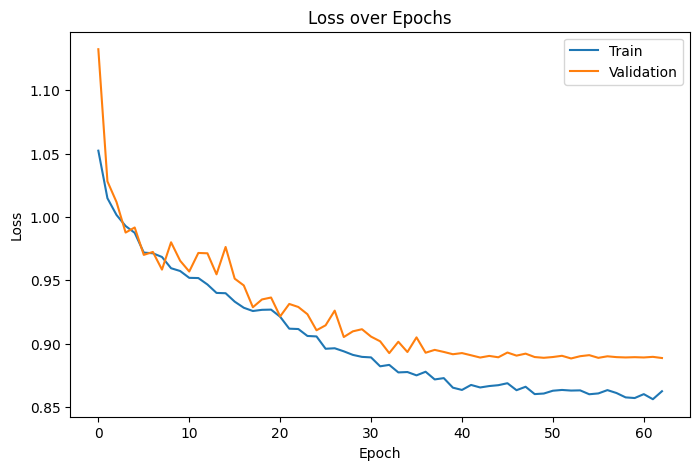

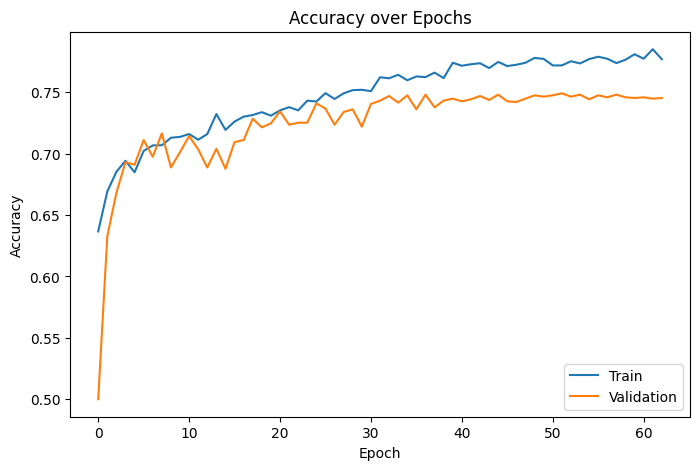

In [ ]:
visualize_modeling_results(model1_history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


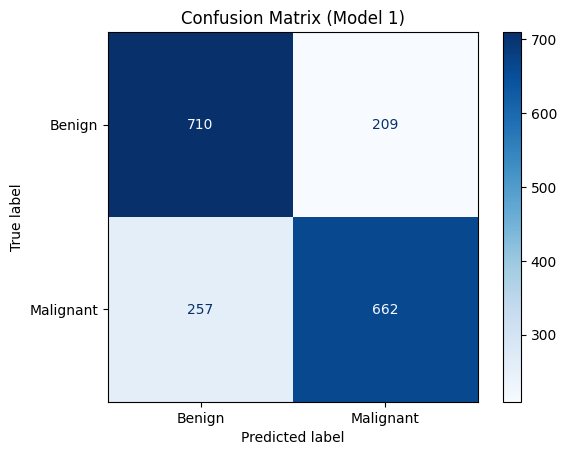

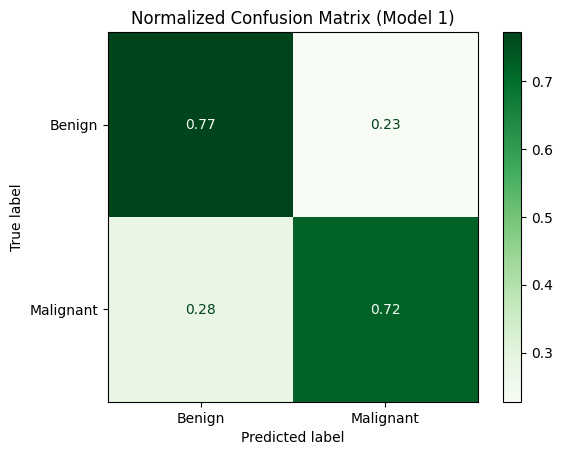

In [ ]:
plot_confusion_matrices_only(model1, val_generator, title_suffix='(Model 1)')

In [ ]:
model1_results = evaluate_model_to_dataframe(
    model1, train_generator, val_generator)

In [ ]:
display(model1_results)

,Loss,Compile_metrics
Train,0.829461,0.801279
Validation,0.888403,0.746464


In [ ]:
save_model_and_results(
    model=model1,
    model_name="model1",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model1_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/model1_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.77      0.76       511
   Malignant       0.76      0.75      0.76       511

    accuracy                           0.76      1022
   macro avg       0.76      0.76      0.76      1022
weighted avg       0.76      0.76      0.76      1022



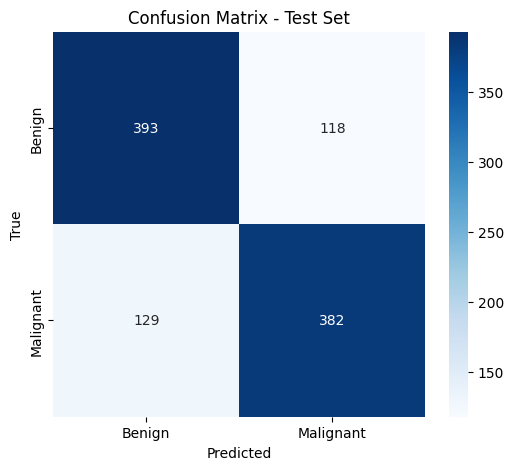

In [ ]:
model = load_model('model1.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
model1.load_weights('/content/model1.keras')

In [ ]:
for layer in model1.layers:
    layer.trainable = True

In [ ]:
model1.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint('model1_finetuned.keras',
                    save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
history_finetune1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - AUC: 0.8643 - Precision: 0.7736 - Recall: 0.7842 - accuracy: 0.7762 - loss: 0.8107
Epoch 1: val_loss improved from inf to 0.84457, saving model to model1_finetuned.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 107s 409ms/step - AUC: 0.8643 - Precision: 0.7736 - Recall: 0.7843 - accuracy: 0.7762 - loss: 0.8107 - val_AUC: 0.8343 - val_Precision: 0.7665 - val_Recall: 0.7323 - val_accuracy: 0.7546 - val_loss: 0.8446 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - AUC: 0.8627 - Precision: 0.7681 - Recall: 0.7890 - accuracy: 0.7769 - loss: 0.8112
Epoch 2: val_loss did not improve from 0.84457
230/230 ━━━━━━━━━━━━━━━━━━━━ 85s 368ms/step - AUC: 0.8627 - Precision: 0.7681 - Recall: 0.7890 - accuracy: 0.7769 - loss: 0.8112 - val_AUC: 0.8309 - val_Precision: 0.7831 - val_Recall: 0.6877 - val_accuracy: 0.7486 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - AUC: 0.

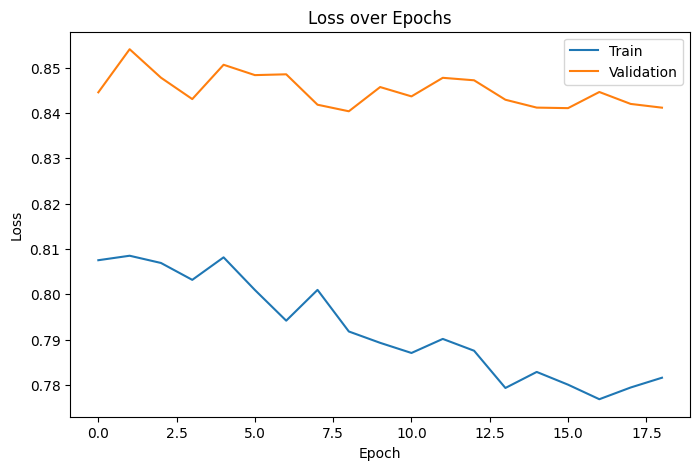

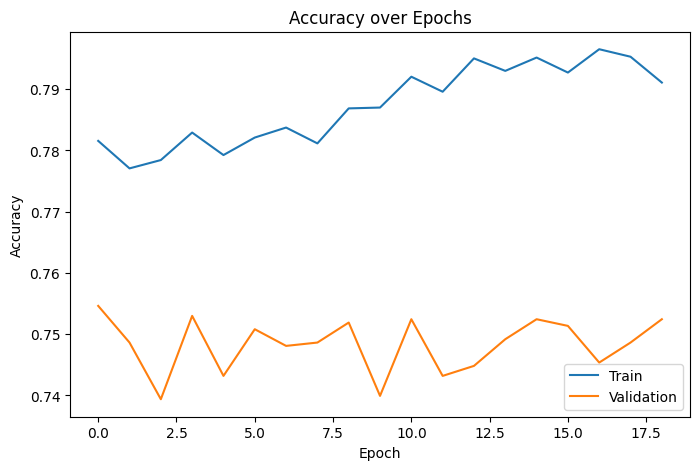

In [ ]:
visualize_modeling_results(history_finetune1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step


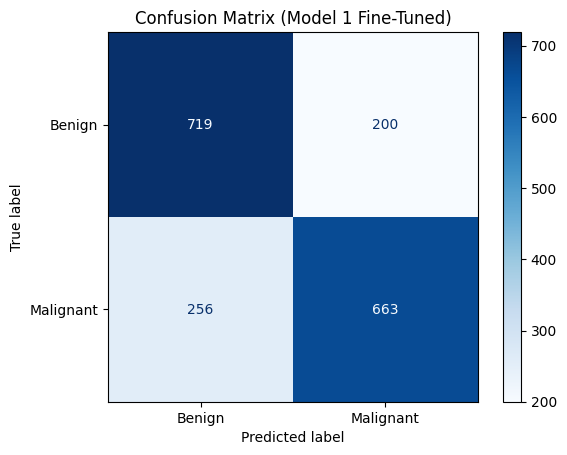

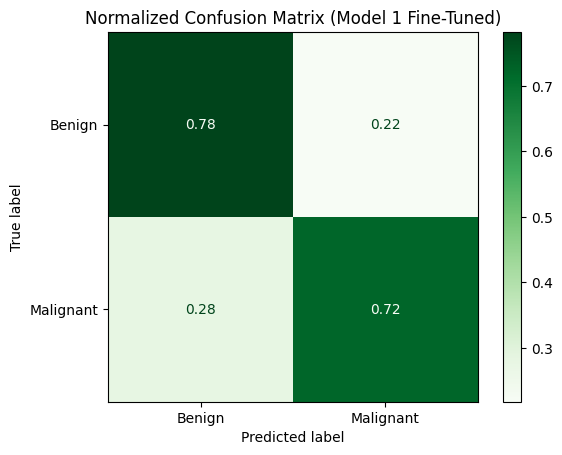

In [ ]:
plot_confusion_matrices_only(
    model1, val_generator, title_suffix='(Model 1 Fine-Tuned)')

In [ ]:
model1_finetuned_results = evaluate_model_to_dataframe(
    model1, train_generator, val_generator)

In [ ]:
display(model1_finetuned_results)

,Loss,Compile_metrics
Train,0.761588,0.803727
Validation,0.840391,0.751904


In [ ]:
save_model_and_results(
    model=model1,
    model_name="model1_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model1_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/model1_finetuned_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.78      0.76       511
   Malignant       0.77      0.74      0.75       511

    accuracy                           0.76      1022
   macro avg       0.76      0.76      0.76      1022
weighted avg       0.76      0.76      0.76      1022



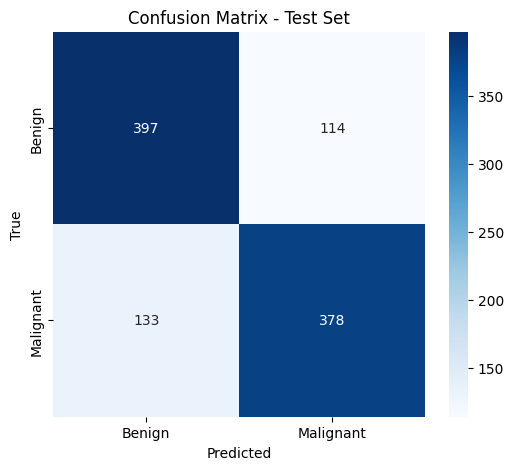

In [ ]:
model = load_model('model1_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### Xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)

output = layers.Dense(1, activation='sigmoid')(x)

xception_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
xception_model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
history_xception = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - AUC: 0.6675 - Precision: 0.5857 - Recall: 0.7934 - accuracy: 0.6085 - loss: 0.9262
Epoch 1: val_loss improved from inf to 0.80823, saving model to xception_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 122s 466ms/step - AUC: 0.6677 - Precision: 0.5859 - Recall: 0.7931 - accuracy: 0.6087 - loss: 0.9259 - val_AUC: 0.7474 - val_Precision: 0.7073 - val_Recall: 0.5680 - val_accuracy: 0.6665 - val_loss: 0.8082 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - AUC: 0.7595 - Precision: 0.6946 - Recall: 0.6765 - accuracy: 0.6881 - loss: 0.7941
Epoch 2: val_loss improved from 0.80823 to 0.78823, saving model to xception_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 91s 395ms/step - AUC: 0.7595 - Precision: 0.6947 - Recall: 0.6765 - accuracy: 0.6881 - loss: 0.7941 - val_AUC: 0.7716 - val_Precision: 0.7233 - val_Recall: 0.6257 - val_accuracy: 0.6931 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 3/100
230/230 ━━━━━━━━━

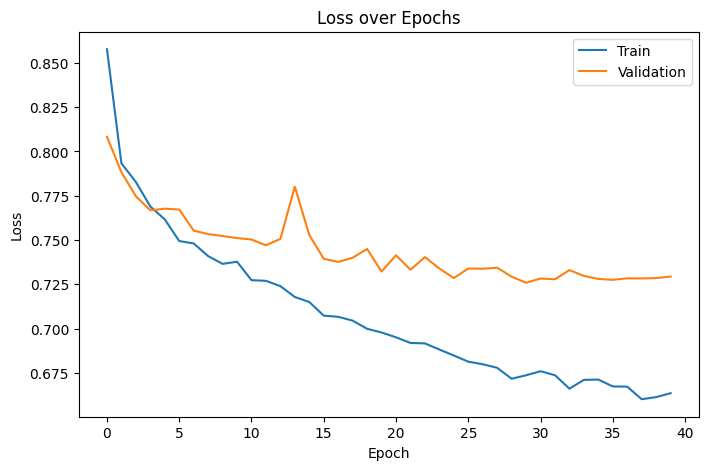

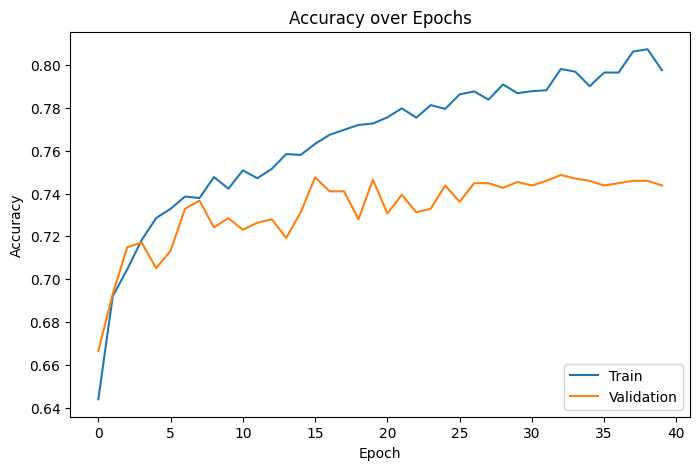

In [ ]:
visualize_modeling_results(history_xception)

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step


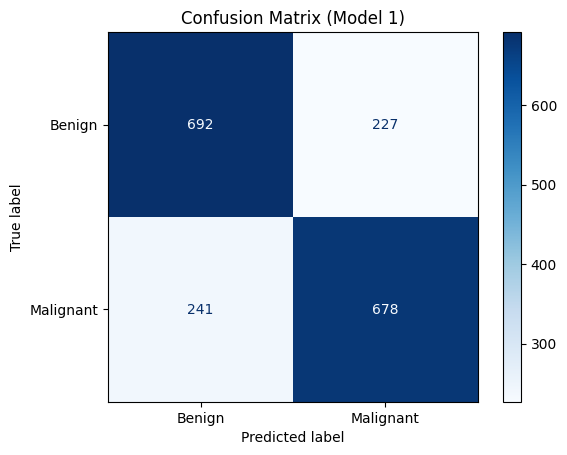

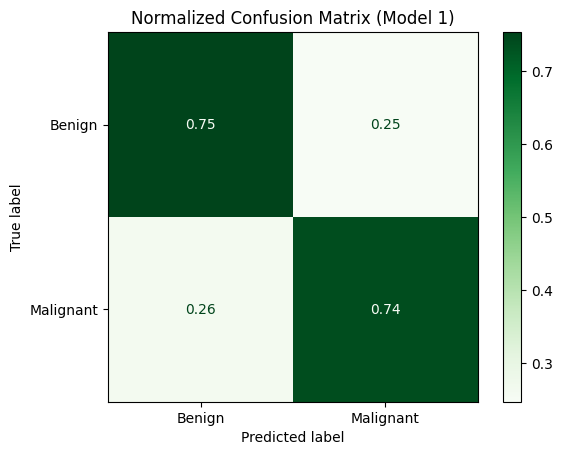

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception)')

In [ ]:
xception_model_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_model_results)

,Loss,Compile_metrics
Train,0.640677,0.819505
Validation,0.725851,0.745375


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_model_results.csv


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.76      0.75      0.76       511
   Malignant       0.75      0.77      0.76       511

    accuracy                           0.76      1022
   macro avg       0.76      0.76      0.76      1022
weighted avg       0.76      0.76      0.76      1022



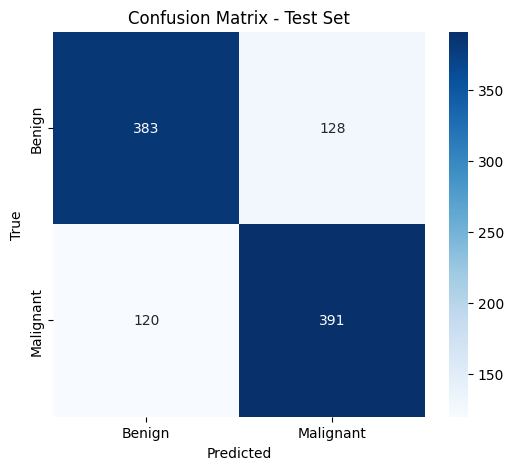

In [ ]:
model = load_model('xception_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
xception_model = load_model("/content/xception_model.keras")

In [ ]:
for layer in xception_model.layers:
    layer.trainable = True

In [ ]:
xception_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
history_xception_finetuned = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - AUC: 0.7094 - Precision: 0.6467 - Recall: 0.6513 - accuracy: 0.6479 - loss: 0.8243
Epoch 1: val_loss improved from inf to 0.74228, saving model to xception_finetuned.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 149s 531ms/step - AUC: 0.7095 - Precision: 0.6468 - Recall: 0.6513 - accuracy: 0.6479 - loss: 0.8242 - val_AUC: 0.7814 - val_Precision: 0.7267 - val_Recall: 0.6627 - val_accuracy: 0.7067 - val_loss: 0.7423 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - AUC: 0.7668 - Precision: 0.7038 - Recall: 0.6827 - accuracy: 0.6990 - loss: 0.7563
Epoch 2: val_loss improved from 0.74228 to 0.73031, saving model to xception_finetuned.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 105s 457ms/step - AUC: 0.7668 - Precision: 0.7039 - Recall: 0.6827 - accuracy: 0.6991 - loss: 0.7562 - val_AUC: 0.7895 - val_Precision: 0.7233 - val_Recall: 0.6768 - val_accuracy: 0.7089 - val_loss: 0.7303 - learning_rate: 1.0000e-04
Epoch 3/50
230

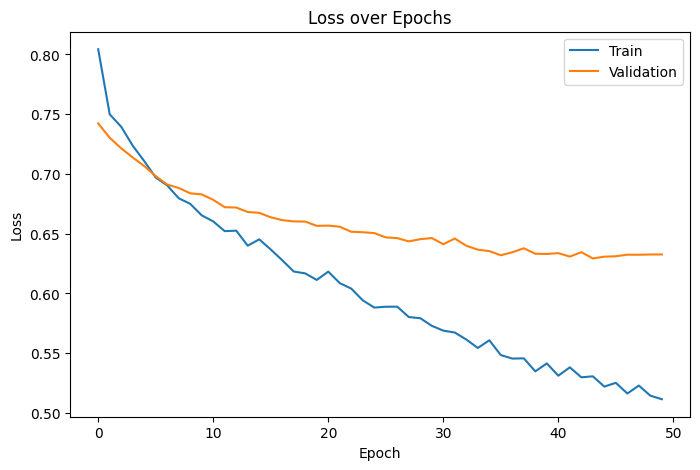

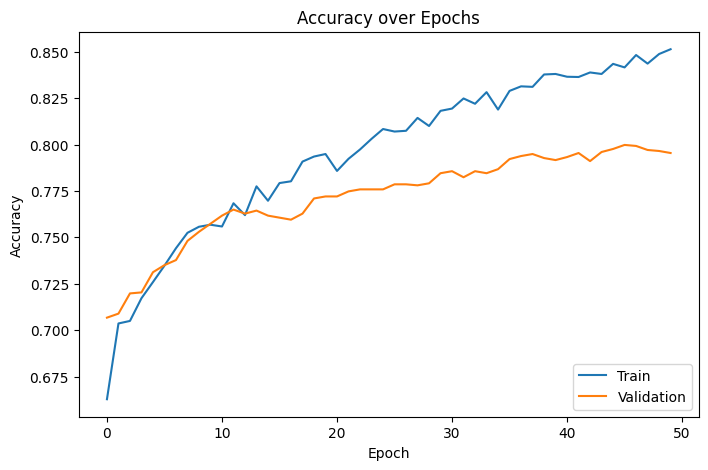

In [ ]:
visualize_modeling_results(history_xception_finetuned)

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step


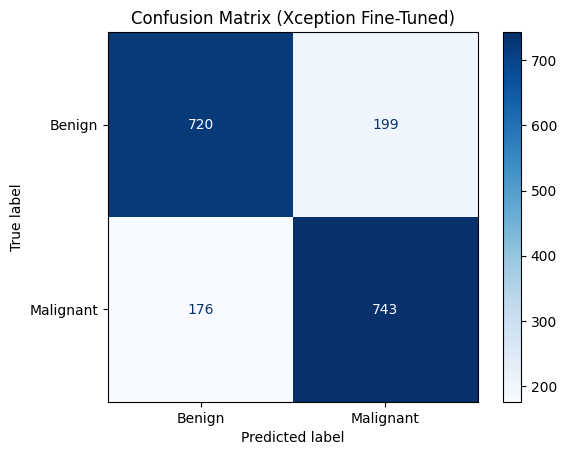

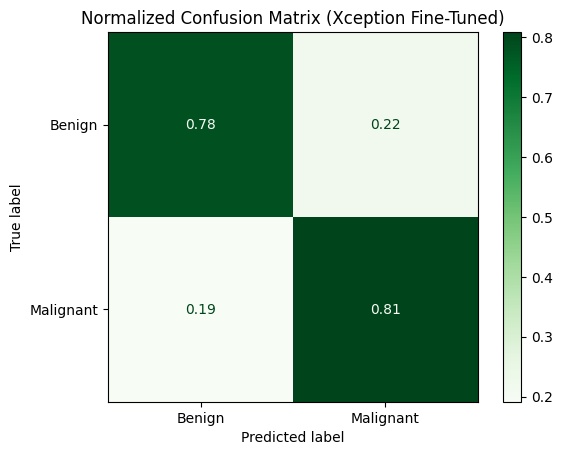

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception Fine-Tuned)')

In [ ]:
xception_finetuned_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_finetuned_results)

,Loss,Compile_metrics
Train,0.472048,0.872688
Validation,0.62932,0.795974


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_finetuned_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.79      0.77      0.78       511
   Malignant       0.78      0.79      0.78       511

    accuracy                           0.78      1022
   macro avg       0.78      0.78      0.78      1022
weighted avg       0.78      0.78      0.78      1022



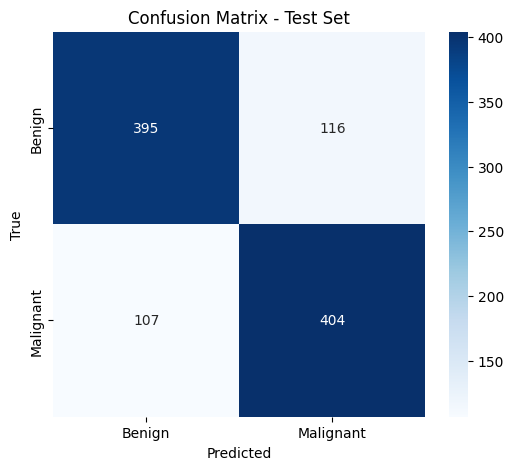

In [ ]:
model = load_model('xception_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### DenseNet121


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(1, activation='sigmoid')(x)

densenet_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - AUC: 0.6683 - Precision: 0.6282 - Recall: 0.6086 - accuracy: 0.6203 - loss: 0.8716
Epoch 1: val_loss improved from inf to 0.79785, saving model to densenet_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 152s 533ms/step - AUC: 0.6685 - Precision: 0.6283 - Recall: 0.6087 - accuracy: 0.6204 - loss: 0.8715 - val_AUC: 0.7590 - val_Precision: 0.6663 - val_Recall: 0.7214 - val_accuracy: 0.6801 - val_loss: 0.7979 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - AUC: 0.7618 - Precision: 0.7010 - Recall: 0.6824 - accuracy: 0.6919 - loss: 0.7973
Epoch 2: val_loss improved from 0.79785 to 0.78717, saving model to densenet_model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 87s 379ms/step - AUC: 0.7618 - Precision: 0.7010 - Recall: 0.6824 - accuracy: 0.6919 - loss: 0.7973 - val_AUC: 0.7795 - val_Precision: 0.6811 - val_Recall: 0.7878 - val_accuracy: 0.7095 - val_loss: 0.7872 - learning_rate: 0.0010
Epoch 3/100
230/230 ━━━━━━━━━

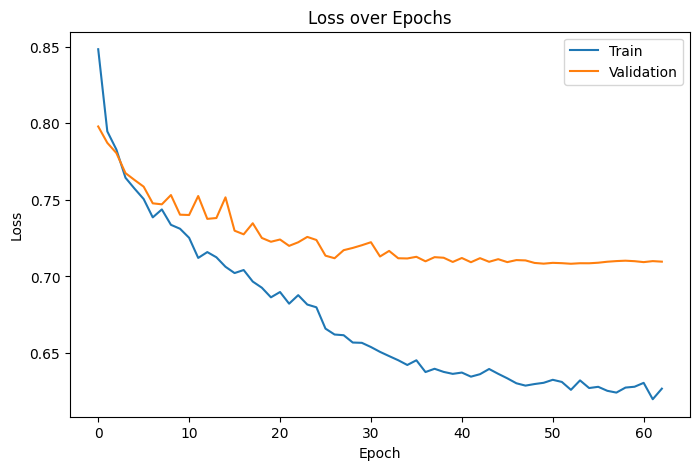

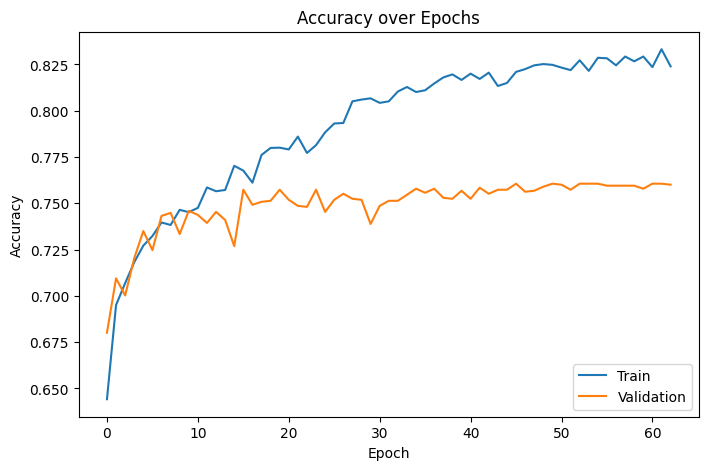

In [ ]:
visualize_modeling_results(history_densenet)

58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step


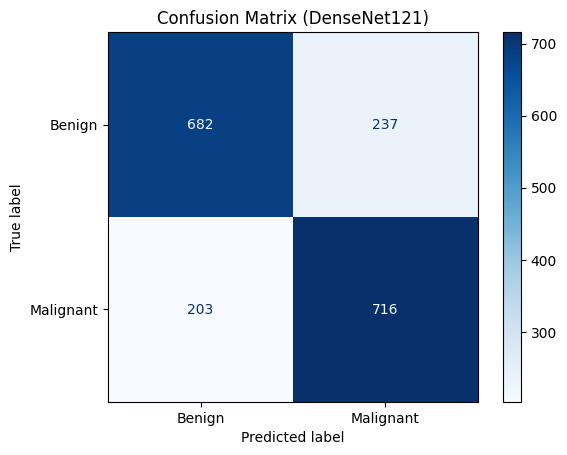

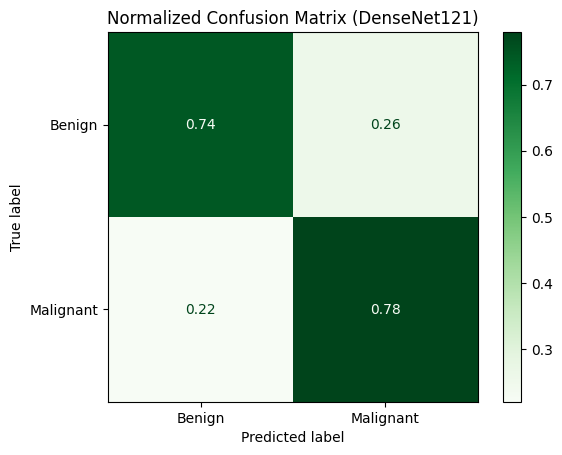

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121)')

In [ ]:
densenet_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_results)

,Loss,Compile_metrics
Train,0.589,0.860038
Validation,0.708252,0.760609


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_model_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 561ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.73      0.75       511
   Malignant       0.75      0.78      0.76       511

    accuracy                           0.76      1022
   macro avg       0.76      0.76      0.76      1022
weighted avg       0.76      0.76      0.76      1022



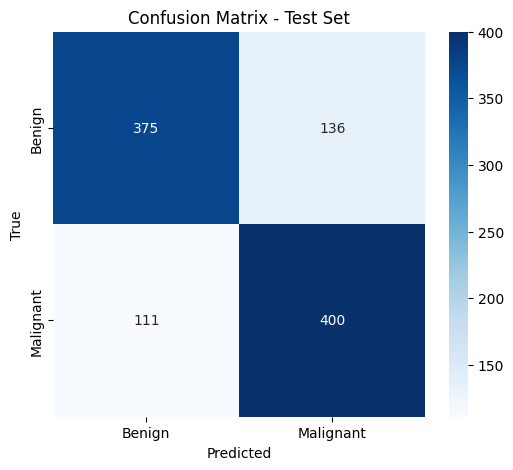

In [ ]:
model = load_model('densenet_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
densenet_model = load_model("/content/densenet_model.keras")

In [ ]:
for layer in densenet_model.layers:
    layer.trainable = True

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
history_densenet_finetuned = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - AUC: 0.7485 - Precision: 0.6823 - Recall: 0.7153 - accuracy: 0.6871 - loss: 0.7911
Epoch 1: val_loss improved from inf to 0.72578, saving model to densenet_finetuned.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 295s 778ms/step - AUC: 0.7486 - Precision: 0.6823 - Recall: 0.7154 - accuracy: 0.6872 - loss: 0.7910 - val_AUC: 0.8030 - val_Precision: 0.7479 - val_Recall: 0.6812 - val_accuracy: 0.7258 - val_loss: 0.7258 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - AUC: 0.8150 - Precision: 0.7255 - Recall: 0.7396 - accuracy: 0.7266 - loss: 0.6986
Epoch 2: val_loss did not improve from 0.72578
230/230 ━━━━━━━━━━━━━━━━━━━━ 85s 368ms/step - AUC: 0.8150 - Precision: 0.7255 - Recall: 0.7396 - accuracy: 0.7267 - loss: 0.6985 - val_AUC: 0.7986 - val_Precision: 0.6398 - val_Recall: 0.8912 - val_accuracy: 0.6948 - val_loss: 0.7755 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - AUC: 

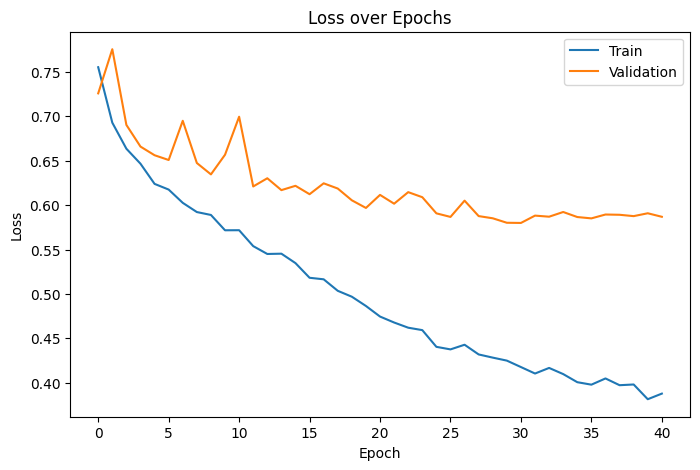

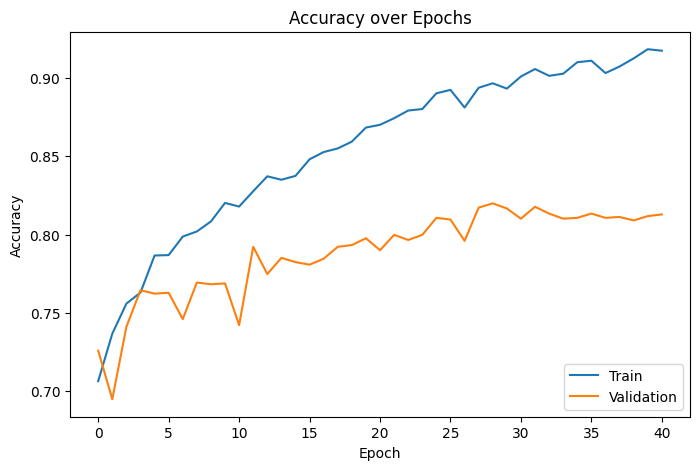

In [ ]:
visualize_modeling_results(history_densenet_finetuned)

58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step


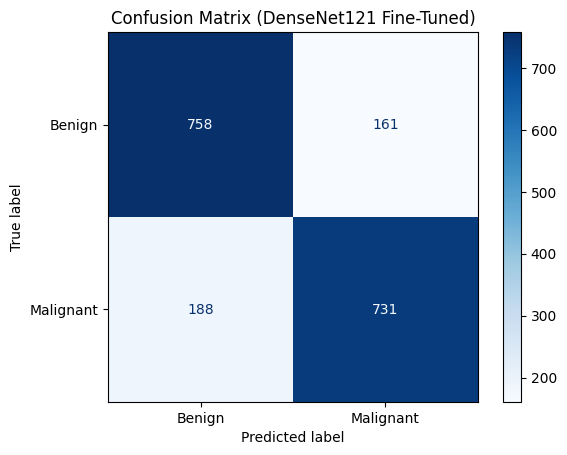

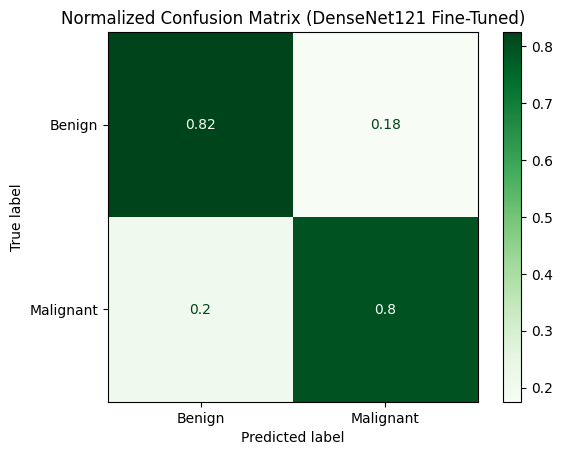

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121 Fine-Tuned)')

In [ ]:
densenet_finetuned_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_finetuned_results)

,Loss,Compile_metrics
Train,0.368219,0.928047
Validation,0.579937,0.81012


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_finetuned_results.csv


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.79      0.81      0.80       511
   Malignant       0.81      0.78      0.79       511

    accuracy                           0.80      1022
   macro avg       0.80      0.80      0.80      1022
weighted avg       0.80      0.80      0.80      1022



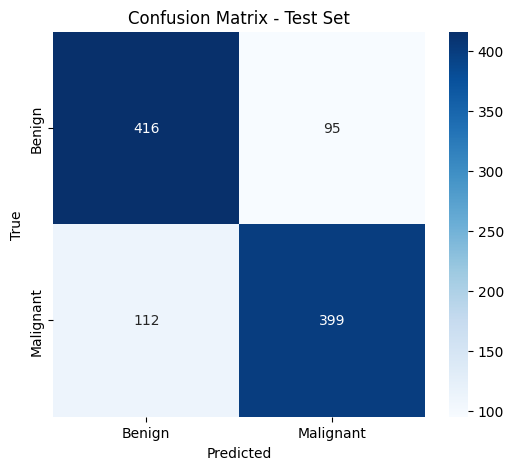

In [ ]:
model = load_model('densenet_finetuned.keras')
evaluate_on_test_set(model, test_generator)

# 3 - Ensemble


In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [26]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 55
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [28]:
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models/melanoma_models"
csv_path = "/content/mel_classification/mel_classification.csv"
image_root = "/content/mel_classification/mel_images"

In [ ]:
df = pd.read_csv(csv_path)
df['label'] = df['target'].astype(int)
df['path'] = df['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))

In [30]:
X = df['path'].values
y = df['label'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

In [32]:
df_train = pd.DataFrame({'path': X_train, 'label': y_train})
df_val = pd.DataFrame({'path': X_val, 'label': y_val})
df_test = pd.DataFrame({'path': X_test, 'label': y_test})

In [33]:
df_test

,path,label
0,/content/mel_classification/mel_images/ISIC_00...,1
1,/content/mel_classification/mel_images/ISIC_00...,0
2,/content/mel_classification/mel_images/ISIC_00...,0
3,/content/mel_classification/mel_images/ISIC_00...,1
4,/content/mel_classification/mel_images/ISIC_00...,0
...,...,...
1017,/content/mel_classification/mel_images/ISIC_00...,1
1018,/content/mel_classification/mel_images/ISIC_00...,0
1019,/content/mel_classification/mel_images/ISIC_00...,0
1020,/content/mel_classification/mel_images/ISIC_00...,0


In [34]:
val_datagen = ImageDataGenerator(rescale=1./255)
cnn_generator = val_datagen.flow_from_dataframe(
    df_test, x_col="path", y_col="label", target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=False, class_mode="raw"
)

Found 1022 validated image filenames.


In [35]:
xception = load_model(os.path.join(model_dir, "xception_finetuned.keras"))
densenet = load_model(os.path.join(model_dir, "densenet_finetuned.keras"))
cnn = load_model(os.path.join(model_dir, "cnn_model.keras"))

In [36]:
def predict_keras(model_path):
    tf.keras.backend.clear_session()
    model = load_model(model_path)
    preds = model.predict(cnn_generator, verbose=1)
    return preds.flatten()

In [ ]:
xception_preds = predict_keras(os.path.join(
    model_dir, "xception_finetuned.keras"))

densenet_preds = predict_keras(os.path.join(
    model_dir, "densenet_finetuned.keras"))

cnn_preds = predict_keras(os.path.join(model_dir, "cnn_model.keras"))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 636ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step


In [38]:
true_labels = df_test['label'].values.astype(int)

In [39]:
true_labels

array([1, 0, 0, ..., 0, 0, 1])

## Soft Voting


In [40]:
soft_preds = (xception_preds + densenet_preds + cnn_preds) / 3
soft_final = (soft_preds > 0.5).astype(int)

== Soft Voting ==
              precision    recall  f1-score   support

           0     0.8168    0.8376    0.8271       511
           1     0.8333    0.8121    0.8226       511

    accuracy                         0.8249      1022
   macro avg     0.8251    0.8249    0.8248      1022
weighted avg     0.8251    0.8249    0.8248      1022



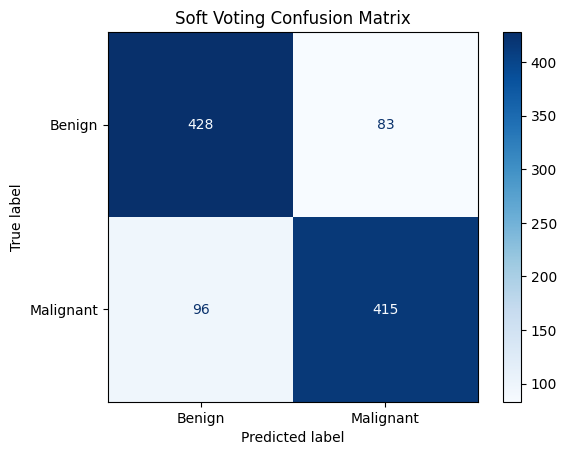

In [ ]:
print("== Soft Voting ==")
print(classification_report(true_labels, soft_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(true_labels, soft_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Soft Voting Confusion Matrix")
plt.show()

## Weighted Soft Voting


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue

        weighted_preds = (
            w1 * densenet_preds +
            w2 * xception_preds +
            w3 * cnn_preds
        )

        pred_labels = (weighted_preds > 0.5).astype(int)
        score = f1_score(true_labels, pred_labels)

        if score > best_score:
            best_score = score
            best_weights = (w1, w2, w3)

print("Best F1 Score:", best_score)
print("Best Weights: DenseNet=%.4f, Xception=%.4f, CNN=%.4f" % best_weights)

Best F1 Score: 0.8234126984126984
Best Weights: DenseNet=0.3000, Xception=0.4000, CNN=0.3000


In [43]:
weighted_preds = (
    0.3 * densenet_preds +
    0.4 * xception_preds +
    0.3 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.8171    0.8395    0.8282       511
           1     0.8350    0.8121    0.8234       511

    accuracy                         0.8258      1022
   macro avg     0.8261    0.8258    0.8258      1022
weighted avg     0.8261    0.8258    0.8258      1022



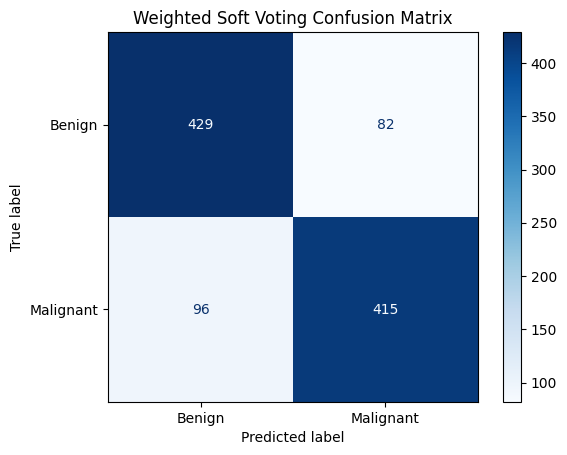

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(true_labels, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(true_labels, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()

# 4 - Final Ensemble Decision


For the binary classification task of melanoma detection—distinguishing between benign and malignant lesions—we applied a weighted soft voting ensemble combining predictions from three individually trained models: DenseNet121, Xception, and a custom CNN. All models were trained with aligned preprocessing, augmentation, and fine-tuning strategies to ensure compatibility during inference.

After evaluating multiple weight combinations, the best performing configuration was determined as:

- DenseNet121: 30%

- Xception: 40%

- CNN: 30%

This configuration yielded:

- Accuracy: 82.58%

- Macro F1-score: 0.8258

- Precision (Benign/Malignant): 0.8171 / 0.8356

- Recall (Benign/Malignant): 0.8395 / 0.8121

The confusion matrix shows balanced predictive performance across both classes, with a slightly higher precision for malignant predictions and stronger recall for benign samples. The ensemble demonstrates reliable generalization on the test set and was selected as the final decision layer in our melanoma classification pipeline.


== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.8171    0.8395    0.8282       511
           1     0.8350    0.8121    0.8234       511

    accuracy                         0.8258      1022
   macro avg     0.8261    0.8258    0.8258      1022
weighted avg     0.8261    0.8258    0.8258      1022



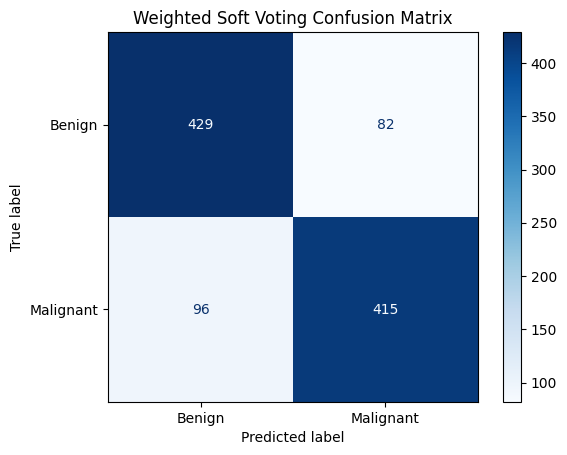

In [ ]:
weighted_preds = (
    0.3 * densenet_preds +
    0.4 * xception_preds +
    0.3 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

print("== Weighted Soft Voting ==")
print(classification_report(true_labels, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(true_labels, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()